# <img src="https://img.icons8.com/dusk/64/000000/mind-map.png" style="height:50px;display:inline"> EE 044165/6 - Technion - Intro to Machine Learning Lab

## Part 2 - K-NN and Perceptron

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda

* Recap of Part 1
    * Loading the Data
    * Data Representation
    * Train-Test Separation
    * Naive Bayes
* K Nearest Neighbors (K-NN)
* The Perceptron
* Final Comparison

#### Notes
* To run a code block, select it (with mouse) and press Ctrl + Enter to run it or Shift + Enter to run it and move on to the next block.
* To get description of functions and classes, run `help(name_of_function)`.
* To display lines in the code block, select the block, press ESC and then 'L'.

In [1]:
# enable auto-reload modules
%reload_ext autoreload
%autoreload 2

# imports for the lab
import functools
from concurrent.futures import ProcessPoolExecutor
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.neighbors import KNeighborsClassifier # import K-NN classifier
from helper_functions import email_pipeline, execute_repeats, get_chunks
from part_1_functions import calc_err


# auxiliary function for multiprocessing
def run_parallel(func, param, n_repeats):
    chunks = get_chunks(n_repeats)
    if __name__ == '__main__':  # needed to work with jupyter + windows
        with ProcessPoolExecutor(max_workers=len(chunks)) as executor:
            outs = executor.map(functools.partial(execute_repeats, func=func, param=param), chunks)
    return sum(outs, [])

## <img src="https://img.icons8.com/dusk/64/000000/rewind.png" style="height:50px;display:inline"> Recap of Part 1
We will now repeat the process of loading the data, pre-processing it and splitting it.

#### Copy & Paste relevant code from the previous lab

In [2]:
# load the data
email_data = pd.read_csv('./email_data.csv')
print("number of samples: ", len(email_data))
print("number of spam emails: ", np.sum(email_data.Label == 'S'))
print("number of ham emails: ", np.sum(email_data.Label == 'H'))


'''  '''
# let's look at 15 random samples from it.
email_data.sample(15)

number of samples:  3052
number of spam emails:  501
number of ham emails:  2551


,To,From,Subject,Content,Label
907,fork@example.com,"""Mr. FoRK"" <fork_list@hotmail.com>",ActiveBuddy,Kind of interesting application of 'agent' tec...,H
357,"'James Tauber' <jtauber@jtauber.com>, fork@exa...",John Hall <johnhall@evergo.net>,My source: RE: A biblical digression,Remember I didn't say it was necessarily a goo...,H
90,"""Larry W. Virden"" <lvirden@cas.org>",unlisted <unlisted@pobox.com>,Re: [scoop] Scoop MS Word .doc file into somet...,"On Thu, 2002-08-29 at 19:27, Barry Dexter A. G...",H
306,eric nichols <matchsprint@trackbike.com>,Michael Conry <michael.conry@ucd.ie>,Re: [ILUG] PCTel modules,"On 0020 -0700 %{!Thu, Sep 05, 2002 at 3:17:36...",H
1767,NaN,gward@python.net,[Spambayes] test sets?,"On 06 September 2002, Tim Peters said:\n> > No...",H
1800,NaN,tim.one@comcast.net,[Spambayes] Maybe change X-Spam-Disposition to...,"[Skip Montanaro, to Anthony Baxter]\n> ...\n> ...",H
299,zzzzteana@yahoogroups.com,Martin Adamson <martin@srv0.ems.ed.ac.uk>,[zzzzteana] Hitler-style applicant welcomed by...,"The Times\n \n \n September 06, 2002\n \n Hitl...",H
901,Elias <fork@example.com>,bitbitch@magnesium.net,Re[2]: So I missed this one...,"Hello Elias,\n\nTuesday, October 1, 2002, 9:54...",H
1889,yyyy-use-perl@example.com,pudge@perl.org,[use Perl] Headlines for 2002-09-14,"use Perl Daily Headline Mailer\n\n""Perl 6: Rig...",H
1607,spamassassin-commits@example.sourceforge.net,Justin Mason <yyyyason@users.sourceforge.net>,[SACVS] CVS: spamassassin/t db_based_whitelist...,Update of /cvsroot/spamassassin/spamassassin/t...,H


In [3]:
from part_1_functions import train_test_split


X = email_data['Content'].values
y = email_data['Label'].values == 'S' # 1 Spam, 0 for Ham


# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# transform
X_train_augmented = email_pipeline.fit_transform(X_train)
X_test_augmented = email_pipeline.transform(X_test)


# get statistics
print("num train samples: ", X_train.shape[0])
print("num test samples: ", X_test.shape[0])
print("shape after augmentation: ", X_train_augmented.shape)
print("fraction of spam in the original: ", np.mean(y == 1))
print("fraction of spam in the train set: ", np.mean(y_train == 1))

num train samples:  2441
num test samples:  611
shape after augmentation:  (2441, 300)
fraction of spam in the original:  0.16415465268676277
fraction of spam in the train set:  0.16550594018844736


In [5]:
# complete the function evaluate_classifier in part_2_functions.py
from part_2_functions import evaluate_classifier

## <img src="https://img.icons8.com/dusk/64/000000/rewind.png" style="height:50px;display:inline"> K Nearest Neighbors
We will now use K-NN classifier to complete the classification task. You will use Scikit-Learn's K-NN Classifier `KNeighborsClassifier`.

Usage:

`clf = KNeighborsClassifier(n_neighbors=K, p=2)` or `KNeighborsClassifier(n_neighbors=K, metric='cosine')`

`clf.fit(X_augmented_train, y_train)`

`y_pred = clf.predict(X_augmented_test)`

In [8]:
# using distances:
# L2 - p=2 [KNeighborsClassifier(n_neighbors=K, p=2)]
# L1 - p=1 [KNeighborsClassifier(n_neighbors=K, p=1)]
# Cosine Distance - metric='cosine' [KNeighborsClassifier(n_neighbors=K, metric='cosine')]

"""
Your Code Here
"""
# # num neighbors
K = 3


# # L2 distance
l2_clf = KNeighborsClassifier(n_neighbors=K, p=2)
l2_error, l2_error_std = evaluate_classifier(l2_clf,X,y,0.2,10)
print(f"L2 distance - error: {100*l2_error:.3f}%, std: {100*l2_error_std:.3f}%")
#
# # L1 distance
l1_clf = KNeighborsClassifier(n_neighbors=K, p=1)
l1_error, l1_error_std = evaluate_classifier(l1_clf,X,y,0.2,10)
print(f"L1 distance - error: {100*l1_error:.3f}%, std: {100*l1_error_std:.3f}%")
#
# # Cosine distance
Cosine_clf = KNeighborsClassifier(n_neighbors=K, metric='cosine')
cos_error, cos_error_std = evaluate_classifier(Cosine_clf,X,y,0.2,10)
print(f"cosine distance -  error: {100*cos_error:.3f}%, std: {100*cos_error_std:.3f}%")



L2 distance - error: 6.579%, std: 1.327%
L1 distance - error: 6.743%, std: 1.227%
cosine distance -  error: 5.434%, std: 1.196%


In [48]:
# summary table
summary_df = pd.DataFrame(100 * np.concatenate([np.array([l2_error, l1_error, cos_error]).reshape(-1, 1),
                                       np.array([1 - l2_error, 1 - l1_error, 1 - cos_error]).reshape(-1, 1),
                                       np.array([l2_error_std, l1_error_std, cos_error_std]).reshape(-1,1)],axis=1),
                       columns=['Error [%]', 'Accuracy  [%]', 'Error STD [%]'], index=['L2', 'L1', 'Cosine'])
summary_df

,Error [%],Accuracy [%],Error STD [%]
L2,6.579378,93.420622,1.327210
L1,6.743044,93.256956,1.226514
Cosine,5.294599,94.705401,1.076066


In [47]:
# performance vs. K
K_s = [1, 3, 5, 7, 15]  # num neighbors
# using distances:
# Cosine Distance - metric='cosine' [KNeighborsClassifier(n_neighbors=K, metric='cosine')]
n_repeats = 10
K_errors = np.zeros(len(K_s))
K_errors_std = np.zeros(len(K_s))


i=0
for k in K_s:

  Cosine_clf = KNeighborsClassifier(n_neighbors=k, metric='cosine')
  K_errors[++i], K_errors_std[++i] = evaluate_classifier(Cosine_clf, X, y,0.2, 10)
  print(K_errors[i])
  i=i+1
# end for
print('done')



0.05368248772504092
0.05433715220949263
0.052373158756137475
0.054173486088379706
0.0635024549918167
done


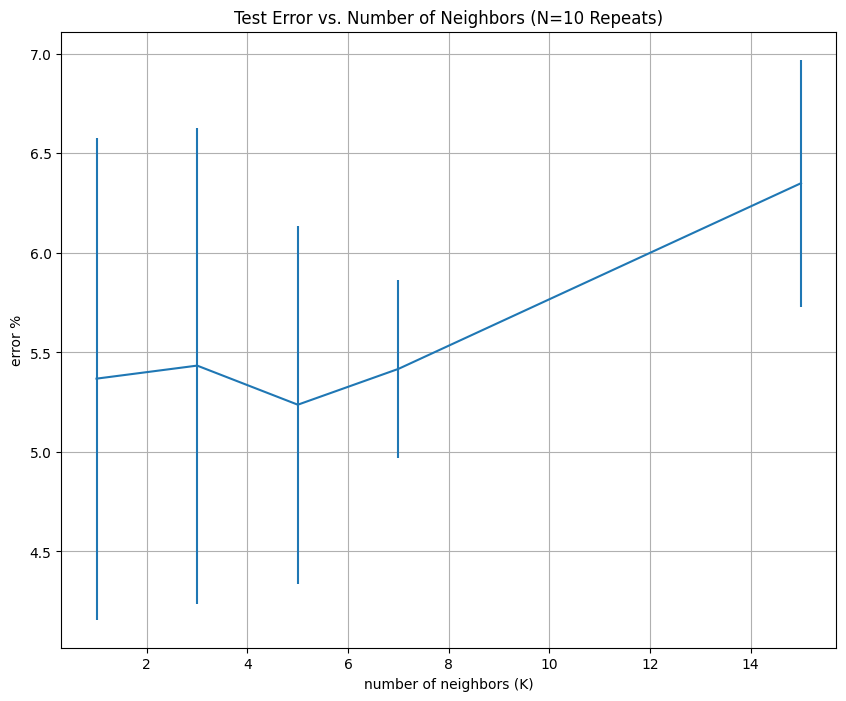

In [20]:
# plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()
ax.errorbar(K_s,100*K_errors,yerr=100*K_errors_std)


ax.set_xlabel("number of neighbors (K)")
ax.set_ylabel("error %")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid()
ax.set_title(f"Test Error vs. Number of Neighbors (N={n_repeats} Repeats)")
plt.show()

### <img src="https://img.icons8.com/color/96/000000/transformer.png" style="height:50px;display:inline"> TF-IDF Transformation
We will now apply TF-IDF transformation as another pre-proccessing stage of the data.

Usage:

`tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)`

`X_augmented_tfidf_train = tfidf_transformer.fit_transform(X_augmented_train)`

`X_augmented_tfidf_test = tfidf_transformer.transform(X_augmented_test)`

In [42]:

# import TF-IDF pre-processor
from sklearn.feature_extraction.text import TfidfTransformer

K = 3  # num neighbors
# using distances:
# Cosine Distance - metric='cosine' [KNeighborsClassifier(n_neighbors=K, metric='cosine')]

n_repeats = 10
test_size = 0.2

# Complete the code of the function compare_tfidf in part_2_functions.py
from part_2_functions import compare_tfidf

# Trial run for the function:
err, err_tfidf = compare_tfidf(X, y, test_size, K)
print(f'Trial run errors: {100*err:.3f}%, {100*err_tfidf:.3f}%', )

#  Run for n_repeats:
outputs = run_parallel(compare_tfidf,
                      [X, y, test_size, K],
                      n_repeats)

errors, errors_tfidf = zip(*outputs)

cos_error = np.mean(errors)
cos_error_std = np.std(errors)
print(f"cosine dist error: {100*cos_error:.3f}%, std: {100*cos_error_std:.3f}%")
cos_error_tfidf = np.mean(errors_tfidf)
cos_error_std_tfidf = np.std(errors_tfidf)
print(f"cosine dist error with TF-IDF: {100*cos_error_tfidf:.3f}%, std: {100*cos_error_std_tfidf:.3f}%")


Trial run errors: 4.419%, 4.746%
cosine dist error: 5.295%, std: 1.076%
cosine dist error with TF-IDF: 5.172%, std: 0.912%


In [49]:
# summary table
summary_df = pd.DataFrame(100 * np.concatenate([np.array([cos_error, cos_error_tfidf]).reshape(-1, 1),
                                       np.array([1 - cos_error, 1 - cos_error_tfidf]).reshape(-1, 1),
                                       np.array([cos_error_std, cos_error_std_tfidf]).reshape(-1,1)],axis=1),
                       columns=['Error', 'Accuracy', 'Error STD'], index=['Cosine' ,'Cosine with TD-IDF'])
summary_df

,Error,Accuracy,Error STD
Cosine,5.294599,94.705401,1.076066
Cosine with TD-IDF,5.171849,94.828151,0.911842


## <img src="https://img.icons8.com/dusk/64/000000/artificial-intelligence.png" style="height:50px;display:inline"> The Perceptron
We will now implement the Perceptron and test its performance.

In [38]:

# Complete the code of the class MlabPerceptron in part_2_functions.py
from part_2_functions import MlabPerceptron


# let's see it in action

X = email_data['Content'].values
y = email_data['Label'].values == 'S'  # 1 Spam, 0 for Ham

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_augmented_train = email_pipeline.fit_transform(X_train)
X_augmented_test = email_pipeline.transform(X_test)

# train and test
n_epochs = 10
alpha = 0.5
perc_clf = MlabPerceptron(n_epochs, alpha)
perc_clf.fit(X_augmented_train, y_train, verbose=True)
y_pred = perc_clf.predict(X_augmented_test)
err = calc_err(y_pred, y_test)
print(f"Perceptron error (using only {n_epochs} epochs): {100*err:.3f}%")

epoch 0: 242 updates
epoch 1: 278 updates
epoch 2: 128 updates
epoch 3: 71 updates
epoch 4: 70 updates
epoch 5: 67 updates
epoch 6: 62 updates
epoch 7: 53 updates
epoch 8: 42 updates
epoch 9: 37 updates
Perceptron error (using only 10 epochs): 2.782%


In [39]:
# let's look at the weights
print(perc_clf.w)

[[   2.     1.   -30.5   16.5   41.5    8.5   -1.5  -33.   -41.    -8.5
   -23.    52.   -87.5  -21.    -7.    24.5  -50.   -82.5  -18.   -61.
    31.5   15.5  -16.5   14.    -4.    13.5  -18.     9.   -14.   -43.
   -51.   -23.    19.   -32.   -95.   -25.   -19.   -33.5  -12.    16.
     6.   -40.    17.    -4.   -41.5   15.   -40.5  -15.5   -2.    78.
   -15.   -75.    32.5  -13.5 -101.    -6.5   60.5  -30.   -30.     9.
    -9.   -41.   -14.   -85.   -24.   -43.   -35.   -28.5  -12.    47.
   -21.5  -20.5  -29.    31.     7.5   10.    13.   -19.5  -29.   110.
    11.   -26.   102.   -36.   -13.   -18.5   46.    -3.5   40.5  -15.5
     2.    -7.     9.   -63.     5.5   -7.    13.5  -44.    60.    54.
    -5.   -44.   -36.   -15.5  -31.    22.     5.5  -17.5    5.   -16.
   -22.5   10.5    5.   -20.    -5.    -9.   -19.5   25.   -24.    -2.
   -26.   -13.   -18.     6.   -40.   -31.   -21.5   64.   -28.    73.
   -18.   -27.   -20.   -24.   -34.5   40.    25.   -17.   -16.    96.
    

In [40]:
n_repeats = 20
n_epochs = 50
alpha = 0.5
from part_2_functions import MlabPerceptron

X = email_data['Content'].values
y = email_data['Label'].values == 'S'  # 1 Spam, 0 for Ham

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_augmented_train = email_pipeline.fit_transform(X_train)
X_augmented_test = email_pipeline.transform(X_test)

perc_clf = MlabPerceptron(n_epochs, alpha)
perc_clf.fit(X_augmented_train, y_train, verbose=True)
y_pred = perc_clf.predict(X_augmented_test)
perc_error,perc_error_std = evaluate_classifier(perc_clf, X, y,0.2,n_repeats)



print(f"perceptron error: {100*perc_error:.3f}%, std: {100*perc_error_std:.3f}%")

epoch 0: 405 updates
epoch 1: 151 updates
epoch 2: 110 updates
epoch 3: 201 updates
epoch 4: 91 updates
epoch 5: 91 updates
epoch 6: 172 updates
epoch 7: 230 updates
epoch 8: 100 updates
epoch 9: 88 updates
epoch 10: 74 updates
epoch 11: 72 updates
epoch 12: 56 updates
epoch 13: 69 updates
epoch 14: 145 updates
epoch 15: 65 updates
epoch 16: 68 updates
epoch 17: 56 updates
epoch 18: 65 updates
epoch 19: 203 updates
epoch 20: 92 updates
epoch 21: 78 updates
epoch 22: 62 updates
epoch 23: 47 updates
epoch 24: 44 updates
epoch 25: 46 updates
epoch 26: 63 updates
epoch 27: 135 updates
epoch 28: 62 updates
epoch 29: 65 updates
epoch 30: 41 updates
epoch 31: 42 updates
epoch 32: 57 updates
epoch 33: 44 updates
epoch 34: 37 updates
epoch 35: 47 updates
epoch 36: 42 updates
epoch 37: 56 updates
epoch 38: 41 updates
epoch 39: 39 updates
epoch 40: 36 updates
epoch 41: 41 updates
epoch 42: 37 updates
epoch 43: 32 updates
epoch 44: 36 updates
epoch 45: 194 updates
epoch 46: 82 updates
epoch 47: 57

In [52]:
n_repeats = 20
n_epochs = 50
alpha = 0.5
from part_2_functions import MlabPerceptron
from part_1_functions import MlabNaiveBayes

X = email_data['Content'].values
y = email_data['Label'].values == 'S'  # 1 Spam, 0 for Ham

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_augmented_train = email_pipeline.fit_transform(X_train)
X_augmented_test = email_pipeline.transform(X_test)

mult_clf = MlabNaiveBayes(dist_type="multinomial_smooth", n_classes=2, use_log_prob=True)
mult_clf.fit(X_augmented_train, y_train)
y_pred = mult_clf.predict(X_augmented_test)
perc_error,perc_error_std = evaluate_classifier(mult_clf, X, y,0.2,n_repeats)



print(f"perceptron error: {100*perc_error:.3f}%, std: {100*perc_error_std:.3f}%")

perceptron error: 2.332%, std: 0.522%


In [55]:
n_repeats = 20
n_epochs = 50
alpha = 0.5
K = 3
from part_2_functions import MlabPerceptron


X = email_data['Content'].values
y = email_data['Label'].values == 'S'  # 1 Spam, 0 for Ham

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_augmented_train = email_pipeline.fit_transform(X_train)
X_augmented_test = email_pipeline.transform(X_test)

KNN_clf = KNeighborsClassifier(n_neighbors=K, metric='cosine')
KNN_clf.fit(X_augmented_train, y_train)
y_pred = KNN_clf.predict(X_augmented_test)
perc_error,perc_error_std = evaluate_classifier(KNN_clf, X, y,0.2,n_repeats)



print(f"perceptron error: {100*perc_error:.3f}%, std: {100*perc_error_std:.3f}%")

perceptron error: 5.295%, std: 1.076%


In [56]:
classified_as_spam = 0
spam = 0
classified_spam = 0

for classf in range(y_pred.shape[0]):
  if y_pred[classf]==0:
    classified_as_spam = classified_as_spam+1
  if y_test[classf]==0:
    spam = spam +1
  if(y_pred[classf]==0 and y_test[classf]==0 ):
     classified_spam = classified_spam+1
print(f"Precision:{classified_as_spam/spam}")
print(f"Recall:{classified_as_spam/classified_spam}")

Precision:0.9769673704414588
Recall:1.0139442231075697


## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com
* Datasets from <a href="https://www.kaggle.com/">Kaggle</a> - https://www.kaggle.com/
* Notebook made by <a href="mailto:taldanielm@campus.technion.ac.il">Tal Daniel</a>
* Updates: Ron Amit (January 2021)